# **Daily Fluctuations in Female Births: An Analysis of California Data (1959)**

## **Abstract**
  This study explores daily variations in female births throughout California for the year 1959. The data set provides a unique opportunity to examine potential factors influencing birth patterns within a specific year. Analyzing these daily fluctuations can offer insights into seasonality, potential healthcare system influences, or even random chance. Understanding these birth patterns can be valuable for healthcare resource allocation, staffing decisions, and potentially uncovering underlying societal trends.

## **Introduction**
The data set at hand focuses on daily counts of female births in California during 1959.
The data is extracted from kaggle :[https://www.kaggle.com/datasets/dougcresswell/daily-total-female-births-in-california-1959/data ]

 Understanding daily birth patterns can offer valuable insights for healthcare systems and society as a whole. This study delves into daily variations in female births across California throughout 1959. Examining these fluctuations within a specific year presents a unique opportunity. We can potentially uncover factors influencing birth patterns beyond seasonal trends.

Traditionally, seasonal variations are a well-documented phenomenon in birth data. However, daily fluctuations might reveal additional influences. These could be related to healthcare delivery systems, such as scheduled inductions or staffing patterns.  Daily variations might also reflect societal trends or even random chance.

By analyzing these daily birth patterns, this study aims to:

* Identify potential factors influencing births beyond seasonality.
* Gain insights valuable for healthcare resource allocation and staffing decisions.
* Uncover underlying societal trends reflected in birth patterns.

This project can contribute to a more comprehensive understanding of factors affecting daily birth variations. This knowledge can then be utilized to optimize healthcare resource allocation, staffing decisions, and potentially even identify emerging societal trends.

## **Step 1**: Description of the data


In [210]:
install.packages('TSA')
install.packages('forecast')
install.packages('astsa')
install.packages("leaps")

library(leaps)
library(TSA)
library(astsa)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [211]:
  library(astsa)

  data<-read.csv(file = "/content/daily-total-female-births-CA.csv") ##read data
  # Parse dates
  data$date <- as.Date(data$date)

  # Check the structure of your data
  str(data)
  ts_data<-ts(data)


'data.frame':	365 obs. of  2 variables:
 $ date  : Date, format: "1959-01-01" "1959-01-02" ...
 $ births: int  35 32 30 31 44 29 45 43 38 27 ...


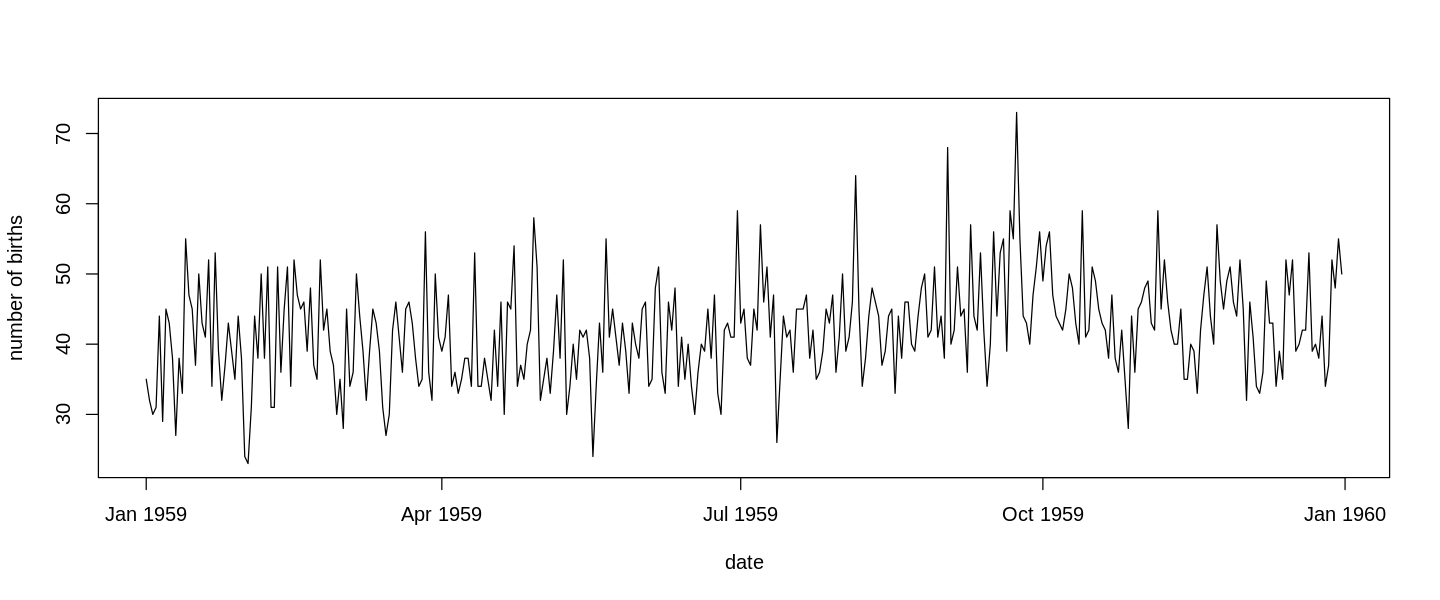

In [212]:
# Adjust plot size
options(repr.plot.width=12, repr.plot.height=5)

# Plot the time series data
plot(data,xlab="date", ylab="number of births",type="l")


Plotting the data shows, that this is not a stationary time series. You can see a trend inside the time series,with a rising number of births till September and afterwards a slight decrease.

Also we can clearly see that the variance is not stablized .

## Split the data into train and test


First we split the data into 90% train and 10% test for forecasting purposes.

In [214]:
# Find the split index
split_index <- floor(0.9 * nrow(data))

# Split the data into training and testing sets
data_train <- data[1:split_index, ]
data_test <- data[(split_index + 1):nrow(data), ]


## **Step 02:** Stabilization of the variance

We use the boxcox function to stabilize the variance to ensure that the variability of the data points remains relatively constant over time

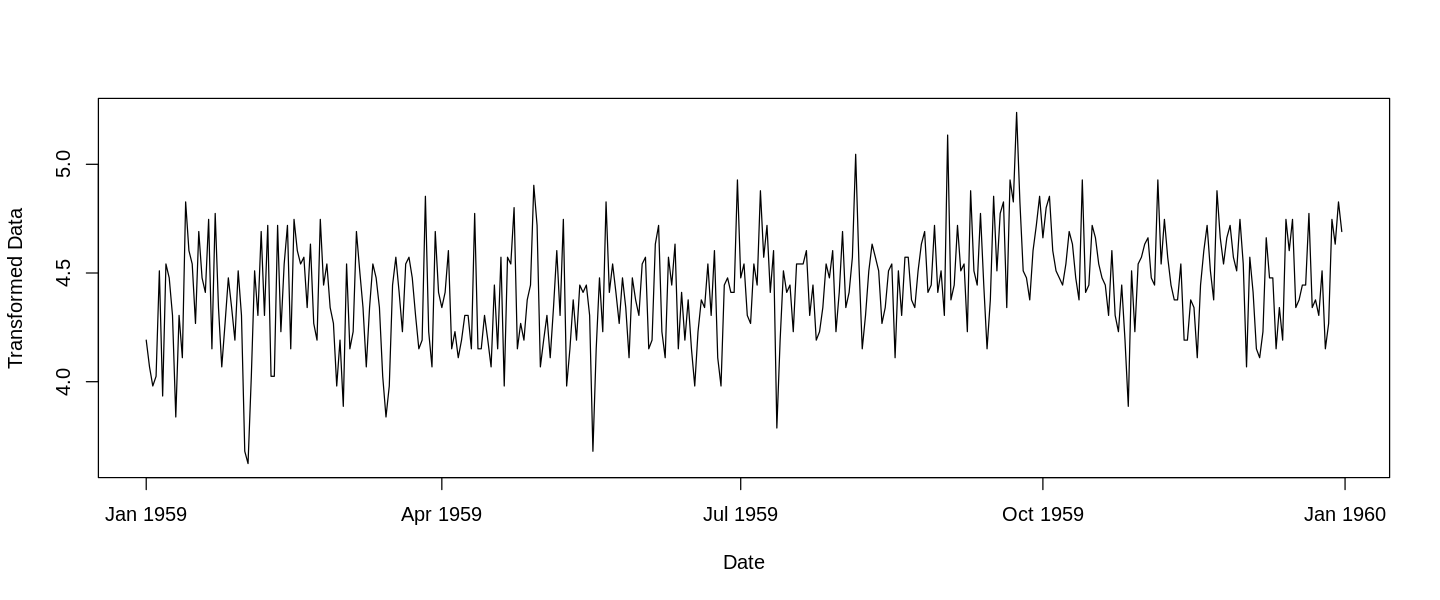

In [216]:
library(forecast)

# Apply the Box-Cox transformation
data_transformed <- BoxCox(data$births, lambda = "auto")

# Plot the transformed data
plot(data$date,data_transformed, xlab="Date", ylab="Transformed Data", type="l")


In [217]:
library(tseries)
adf.test(data_transformed)

Warning message in adf.test(data_transformed):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data_transformed
Dickey-Fuller = -5.1962, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


According to the p-value < 0.05, the hypothesis is correct and the data is non-stationary.  So we need to do the first differences to eliminate the linear trend that we have.

## **Step 03:** Difference  the data

We do the first difference to remove trend effects, making the data stationary and suitable for modeling with methods like ARIMA, which assume stationarity for accurate forecasts.

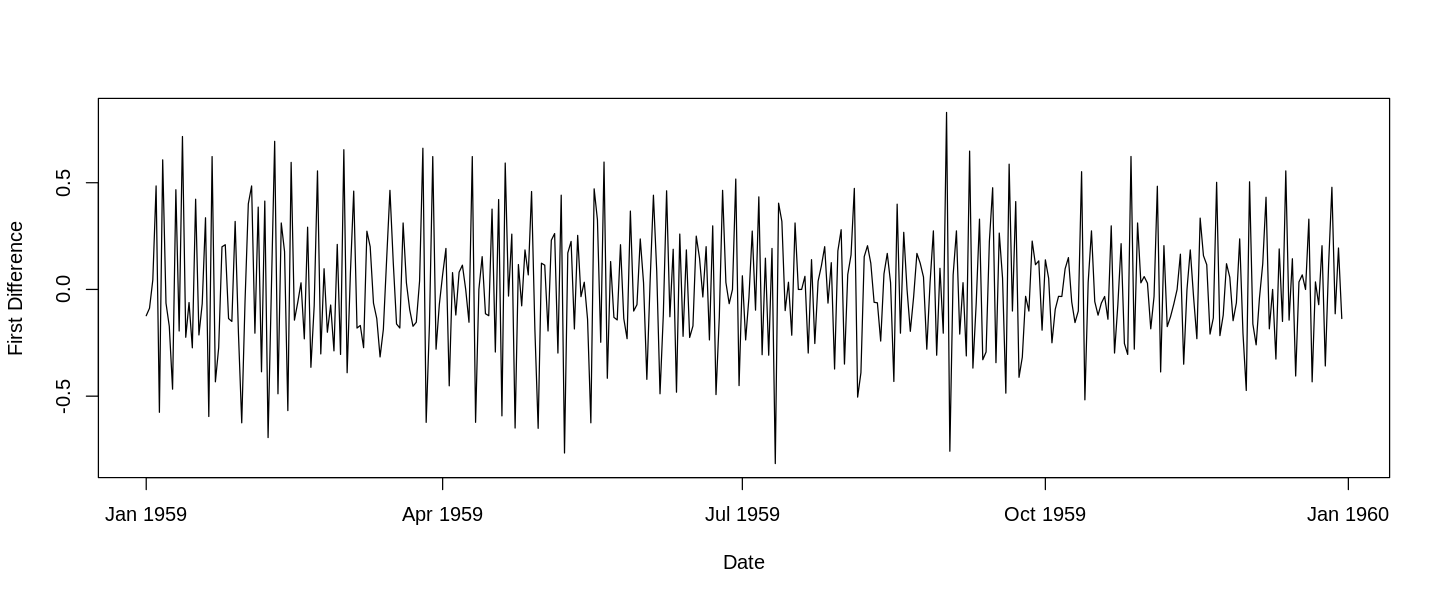

In [218]:
 data_diff<-diff(data_transformed)
plot(data$date[1:364], data_diff, xlab="Date", ylab="First Difference", type="l")


## **Step 04: Plot ACF and PACF**

We plot the ACF and PACF plots of the differenced data to help identifying the ARIMA model parameters p and q

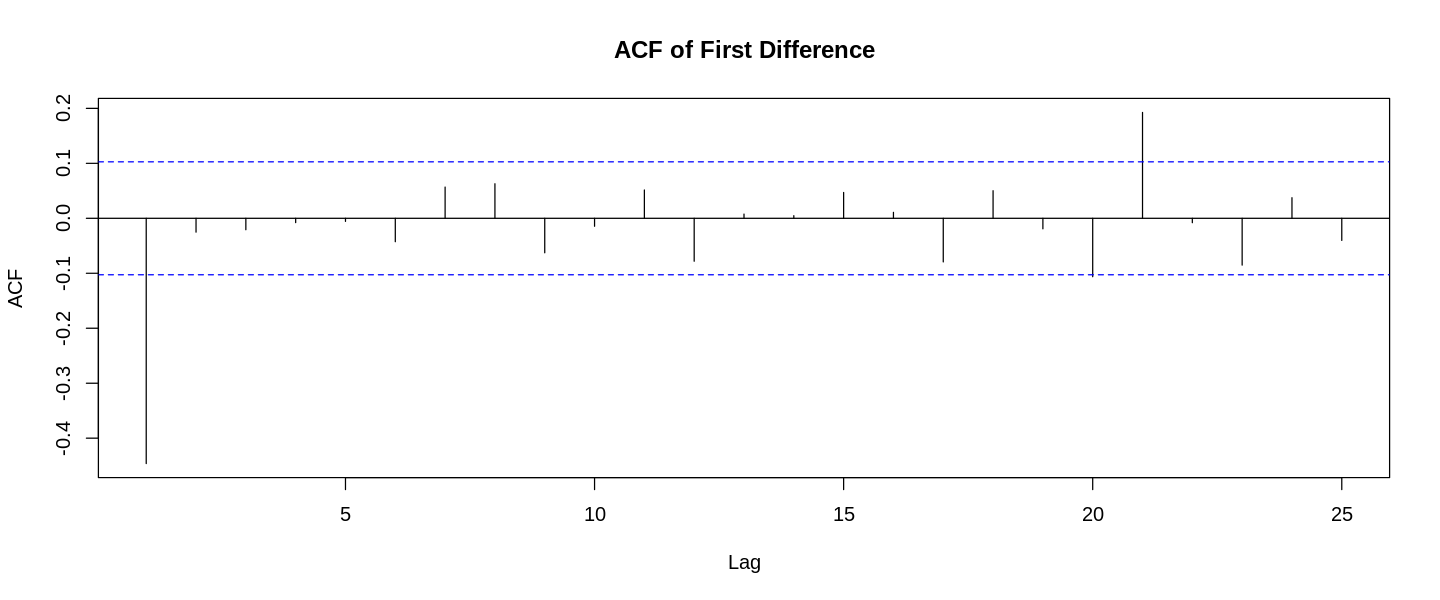

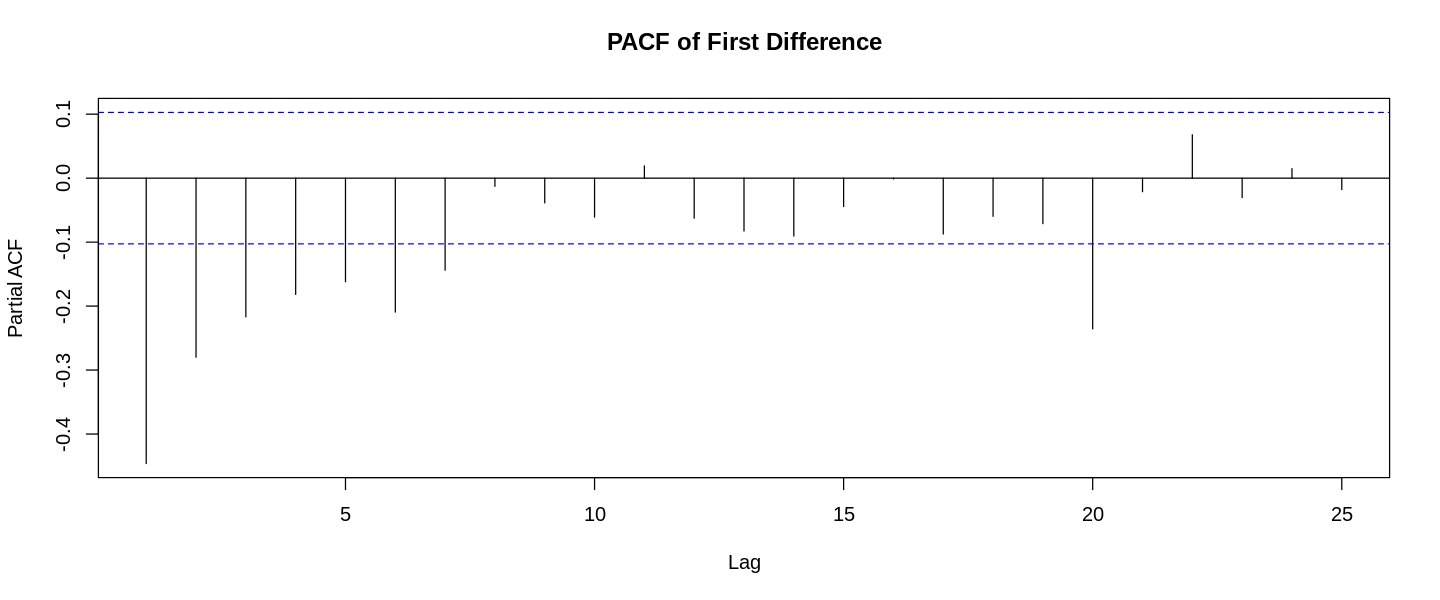

In [219]:
# Plot the ACF of the differenced data
acf_data_diff <- acf(data_diff, main = "ACF of First Difference", )

# Plot the PACF of the differenced data
pacf_data_diff <- pacf(data_diff, main = "PACF of First Difference",)



*   Let's have a look at the ACF of the differenced data. We can see, there is a significant lag at lag 1 and lag 21 (which we probably can ignore here).
*   If we look at the PACF, we see a lot of significant lags (lag 1:7 and lag 21)


---


We have many models to try. Let's look at different arima models. We use for the order (p,d,q) different values obtained from our analysis above.

p comes from the PACF and varies between 0 and 7 d is defined by the difference, we used earlier. q is determined via ACF and is set to 1 or 2.





## **Step 05:** Model specifications

We use for the evaluation of the different models the Akaike information criterion(**AIC**), Bayesian Information Criterion(**BIC**), the standard squared error and the p-Value to thest the autocorrelation of the residuals.

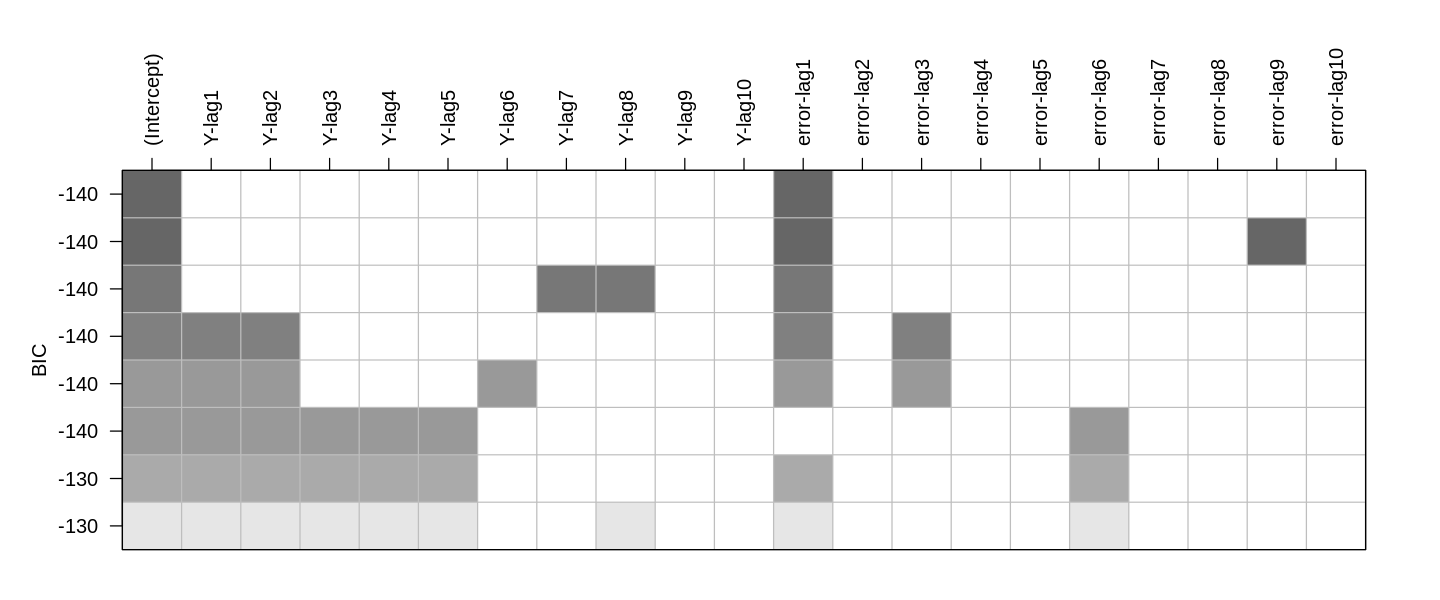

In [220]:
bic_values <- armasubsets(data_diff, nar =10, nma = 10)

#plot
plot(bic_values)

In [221]:
auto_model <- auto.arima(data_diff)

summary(auto_model)

Series: data_diff 
ARIMA(0,0,2) with zero mean 

Coefficients:
          ma1      ma2
      -0.8301  -0.1292
s.e.   0.0497   0.0493

sigma^2 = 0.05485:  log likelihood = 11.66
AIC=-17.32   AICc=-17.25   BIC=-5.63

Training set error measures:
                     ME     RMSE       MAE MPE MAPE      MASE         ACF1
Training set 0.01572041 0.233563 0.1845139 NaN  Inf 0.4452055 0.0008377274

#### **auto.arima** shows that the best model is ARIMA(0,0,2) for the differenced data which means for our original data d=1 because we applied first difference so the model would be ARIMA(0,1,2).
But we apply further analysis

In [222]:
results <- list()

# Define the range for p and q
p <- 0:7
d <- 1
q <- 1:2

# Loop over each combination of p and q
for (i in p) {
  for (j in q) {
    # Fit ARIMA model on training data
    model <- arima(data_train$births, order = c(i, d, j))

    # Calculate residuals on testing data
    residuals <- residuals(model, newdata = test_data)

    # Calculate SSE
    sse <- sum(residuals^2)

    # Calculate Ljung-Box test
    test <- Box.test(residuals, lag = round(log(length(residuals))), type = "Ljung-Box")

    # Store results
    results[[paste("Arima", i, d, j, sep = ",")]] <- list(
      "AIC" = AIC(model),
      "SSE" = sse,
      "p-values" = test$p.value
    )
  }
}

# Print results
print(results)

$`Arima,0,1,1`
$`Arima,0,1,1`$AIC
[1] 2217.61

$`Arima,0,1,1`$SSE
[1] 16558.99

$`Arima,0,1,1`$`p-values`
[1] 0.7507224


$`Arima,0,1,2`
$`Arima,0,1,2`$AIC
[1] 2216.454

$`Arima,0,1,2`$SSE
[1] 16396.3

$`Arima,0,1,2`$`p-values`
[1] 0.9914267


$`Arima,1,1,1`
$`Arima,1,1,1`$AIC
[1] 2216.154

$`Arima,1,1,1`$SSE
[1] 16380.86

$`Arima,1,1,1`$`p-values`
[1] 0.9958783


$`Arima,1,1,2`
$`Arima,1,1,2`$AIC
[1] 2217.321

$`Arima,1,1,2`$SSE
[1] 16247.22

$`Arima,1,1,2`$`p-values`
[1] 0.8175482


$`Arima,2,1,1`
$`Arima,2,1,1`$AIC
[1] 2217.62

$`Arima,2,1,1`$SSE
[1] 16353.55

$`Arima,2,1,1`$`p-values`
[1] 0.999738


$`Arima,2,1,2`
$`Arima,2,1,2`$AIC
[1] 2219.62

$`Arima,2,1,2`$SSE
[1] 16353.58

$`Arima,2,1,2`$`p-values`
[1] 0.9997394


$`Arima,3,1,1`
$`Arima,3,1,1`$AIC
[1] 2219.603

$`Arima,3,1,1`$SSE
[1] 16352.68

$`Arima,3,1,1`$`p-values`
[1] 0.9997509


$`Arima,3,1,2`
$`Arima,3,1,2`$AIC
[1] 2221.556

$`Arima,3,1,2`$SSE
[1] 16351.05

$`Arima,3,1,2`$`p-values`
[1] 0.9989813


$`Arima,4,1,1`
$`Arim

In [223]:
# Initialize an empty dataframe
result_df <- data.frame(
  Model = character(length(results)),
  AIC = numeric(length(results)),
  SSE = numeric(length(results)),
  P_Value = numeric(length(results))
)

# Populate the dataframe with results
for (i in 1:length(results)) {
  result_df[i, "Model"] <- names(results)[i]
  result_df[i, "AIC"] <- results[[i]]$AIC
  result_df[i, "SSE"] <- results[[i]]$SSE
  result_df[i, "P_Value"] <- results[[i]]$`p-value`
}

# Print the dataframe
print(result_df)


         Model      AIC      SSE   P_Value
1  Arima,0,1,1 2217.610 16558.99 0.7507224
2  Arima,0,1,2 2216.454 16396.30 0.9914267
3  Arima,1,1,1 2216.154 16380.86 0.9958783
4  Arima,1,1,2 2217.321 16247.22 0.8175482
5  Arima,2,1,1 2217.620 16353.55 0.9997380
6  Arima,2,1,2 2219.620 16353.58 0.9997394
7  Arima,3,1,1 2219.603 16352.68 0.9997509
8  Arima,3,1,2 2221.556 16351.05 0.9989813
9  Arima,4,1,1 2221.558 16350.45 0.9998974
10 Arima,4,1,2 2219.816 16072.34 0.9999269
11 Arima,5,1,1 2223.552 16350.12 0.9998642
12 Arima,5,1,2 2225.234 16333.81 0.9998821
13 Arima,6,1,1 2225.540 16349.54 0.9999603
14 Arima,6,1,2 2227.057 16325.09 0.9999897
15 Arima,7,1,1 2223.494 16145.59 0.9999897
16 Arima,7,1,2 2224.886 16115.89 0.9999973


#### From all the models we can see, that the p-Value is very high. So we can not reject the Null-Hypothesis, which states that there is no autocorrelation in the data. Or less complicated: the assume, there is no autocorrelation in the residuals of the fitted model. Arima(2,1,1) has the lowest AIC value, while the smallest error has Arima(7, 1, 2).


## **Step 06:** Residuals analysis
Now, let's have a closer look at the Arima models (0,1,2);(2,1,1) and (7,1,2).

In [224]:
# Fit an ARIMA model
model <- arima(data_train$births, order=c(0,1,2))
model_1 <- arima(data_train$births, order=c(2,1,1))
model_2 <- arima(data_train$births, order=c(7,1,2))

# Print the summary of the model
summary(model)
summary(model_1)
summary(model_2)


Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
arima(x = data_train$births, order = c(0, 1, 2))

Coefficients:
          ma1      ma2
      -0.8584  -0.0947
s.e.   0.0529   0.0530

sigma^2 estimated as 50.14:  log likelihood = -1105.23,  aic = 2214.45

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN

Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
arima(x = data_train$births, order = c(2, 1, 1))

Coefficients:
         ar1     ar2      ma1
      0.1089  0.0424  -0.9631
s.e.  0.0578  0.0579   0.0174

sigma^2 estimated as 50.01:  log likelihood = -1104.81,  aic = 2215.62

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN

Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
arima(x = data_train$births, order = c(7, 1, 2))

Coefficients:
         ar1     ar2     ar3      ar4     ar5      ar6     ar7      ma1     ma2
      0.3627  0.0212  0.0059  -0.0082  0.0097  -0.0136  0.1208  -1.2202  0.2400
s.e.  0.2873  0.0677  0.0609   0.0595  0.0595   0.0597  0.0575   0.2863  0.2768

sigma^2 estimated as 49.28:  log likelihood = -1102.44,  aic = 2222.89

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN

According to the summaries of each model, we can see that the most effective model would be ARIMA(0,1,2), so we continue our analyzis using teh ARMA(0,1,2)

Warning message in adf.test(residuals):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  residuals
Dickey-Fuller = -6.0779, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


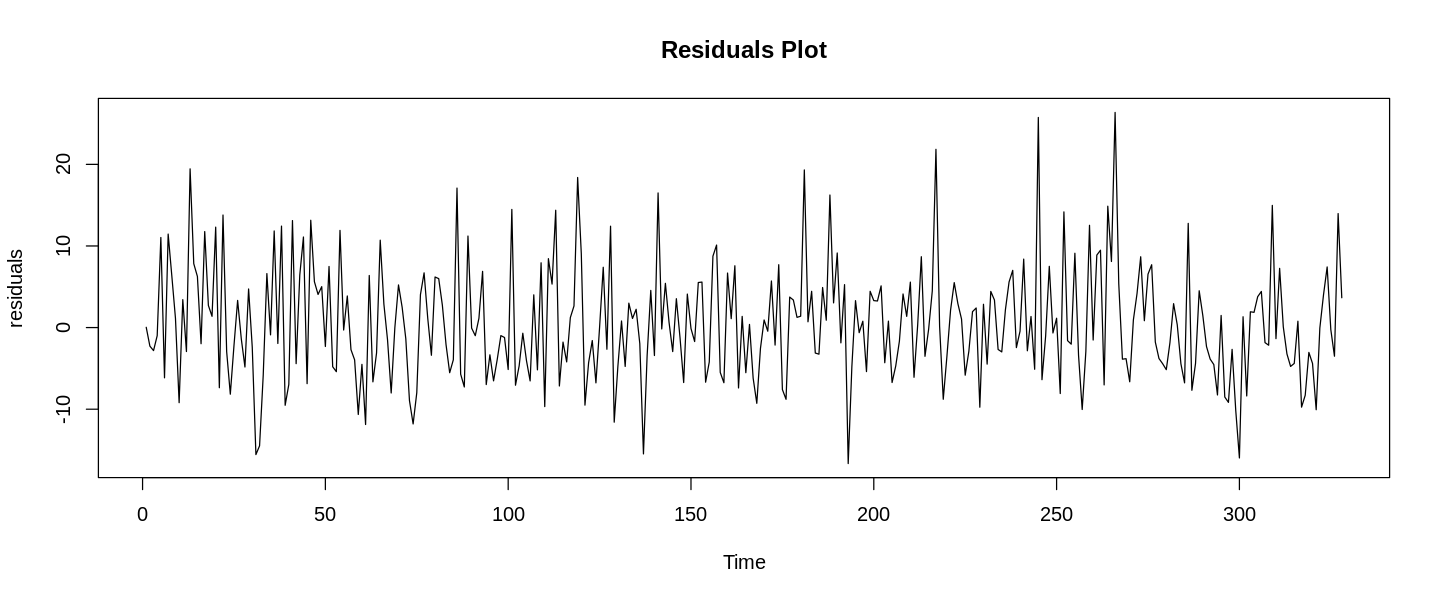

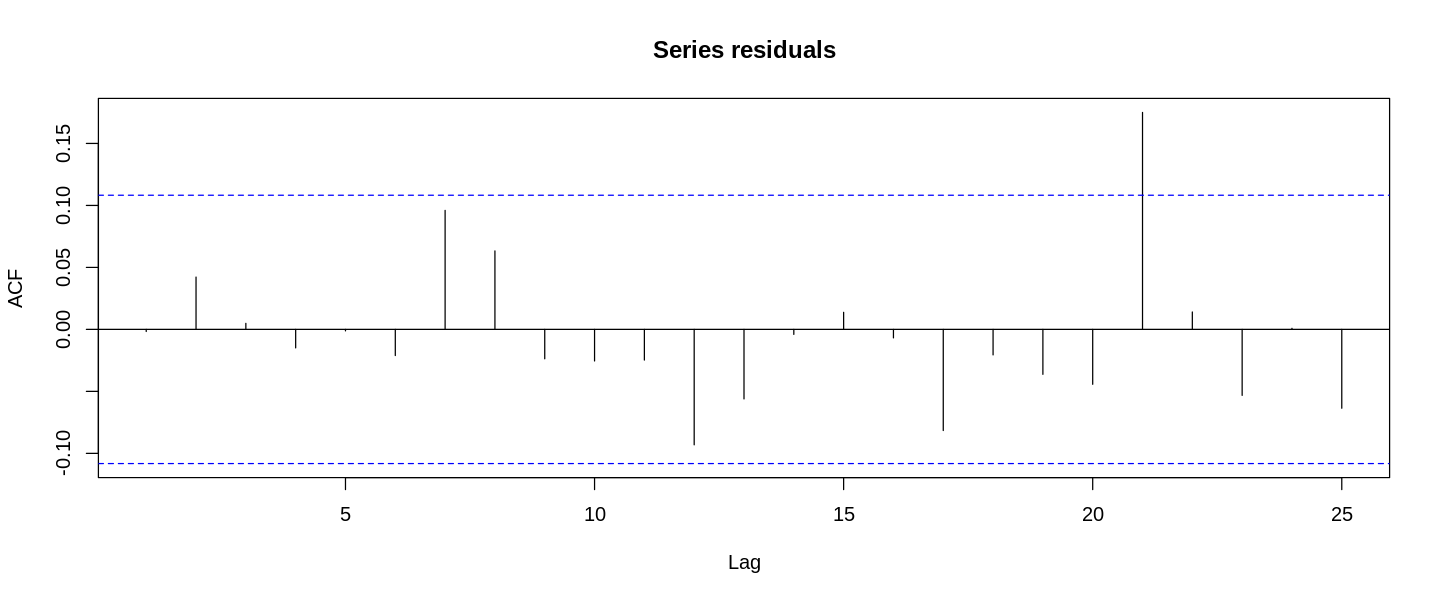

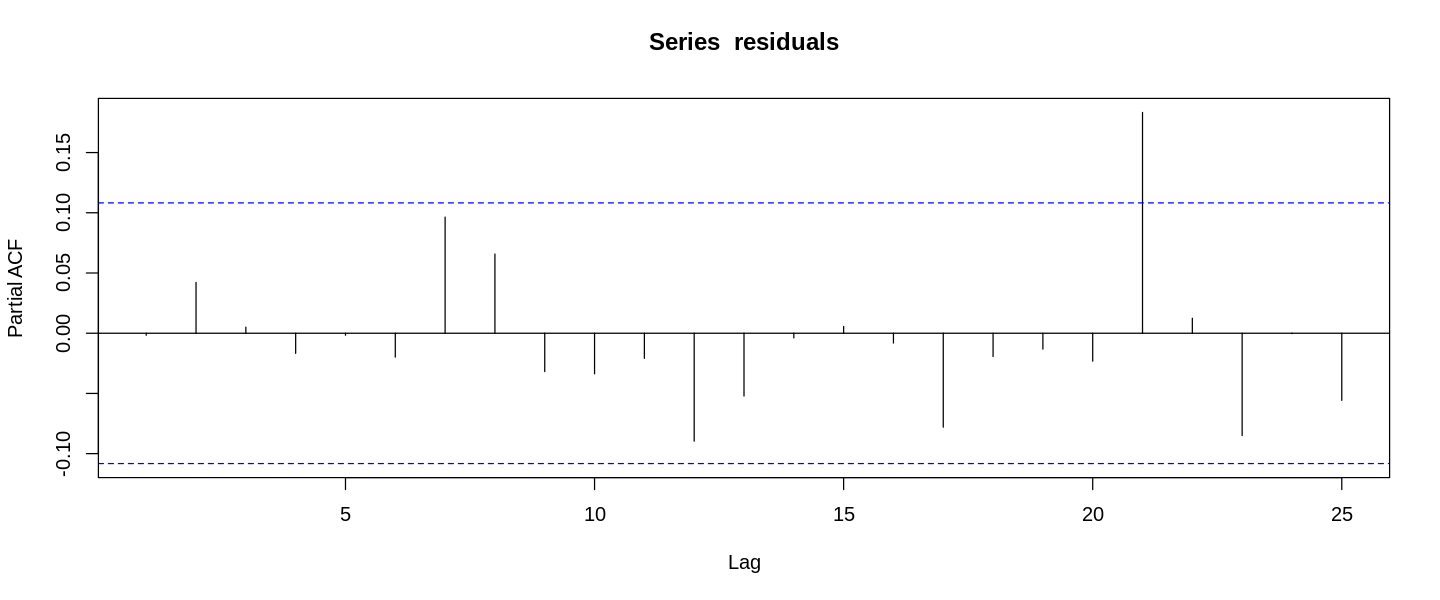

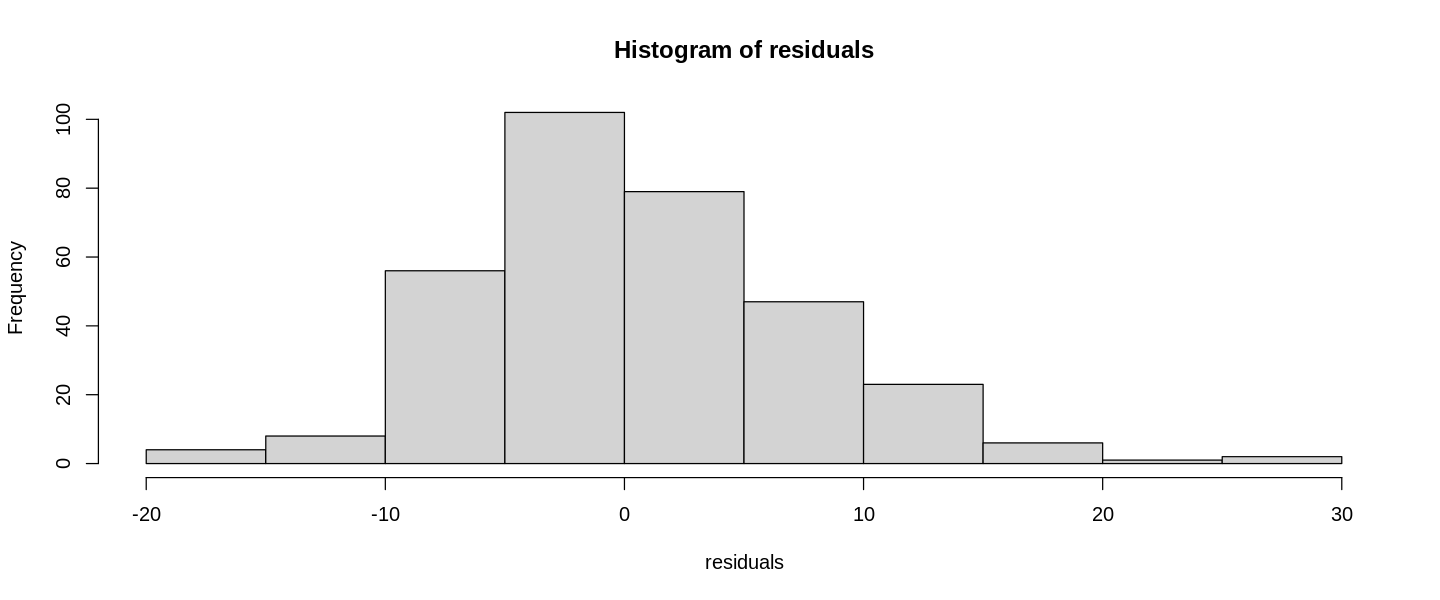

$pvalue
[1] 0.68

$observed.runs
[1] 169

$expected.runs
[1] 164.7805

$n1
[1] 170

$n2
[1] 158

$k
[1] 0


	Shapiro-Wilk normality test

data:  residuals
W = 0.9775, p-value = 5.193e-05


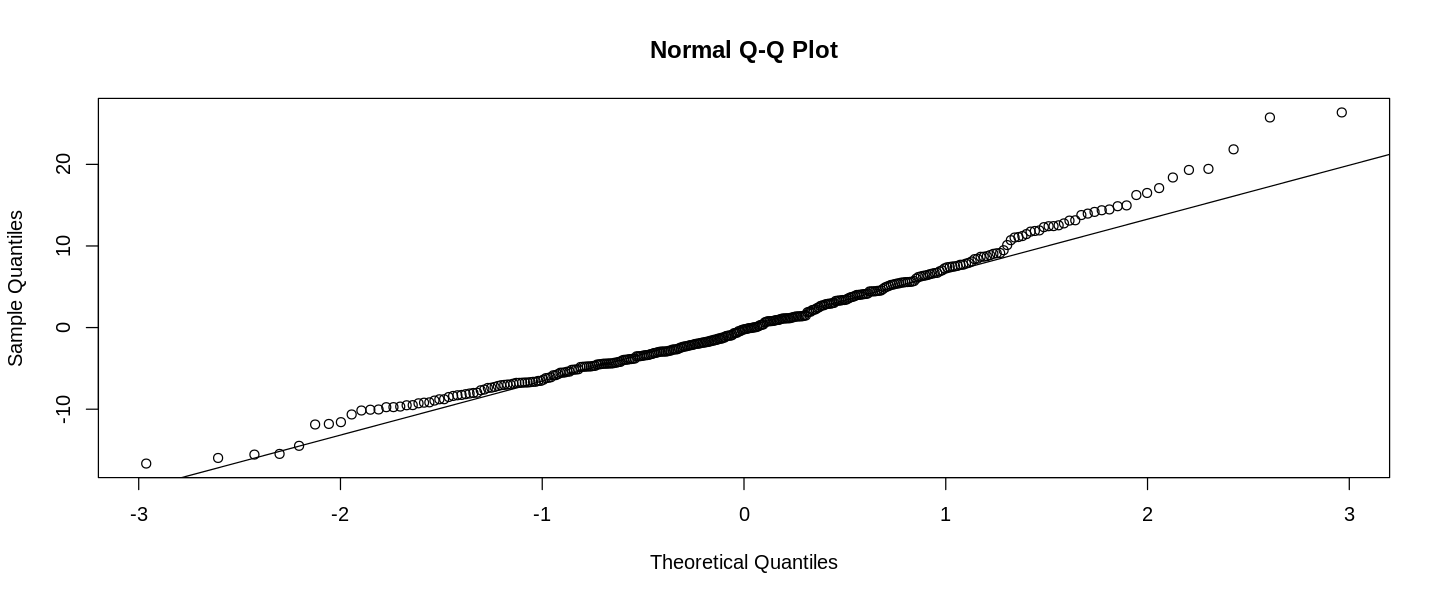

In [225]:
residuals <- residuals(model)

# 1. Check for Stationarity
adf.test(residuals)

# 2. Plot the Residuals
plot(residuals, type = "l", main = "Residuals Plot")

# 3. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
# Example:
acf(residuals)
pacf(residuals)

# 4. Normality
# Histogram
hist(residuals)
# Q-Q plot
qqnorm(residuals)
qqline(residuals)
# runs test
runs(residuals)
#shapiro test
shapiro.test(residuals)


###**results**:
*   The Dickey-fuller test shows that p-value < 0.05 which means that the null hypothesis is rejected. Thus, we accept the alternative hypothesis which means the residuals are stiationary.
*   The ACF plot of the residuals shows no significant autocorrelation at any of the lags. This is a good sign, as it suggests that the errors are independent and identically distributed (iid)
*   PACF also suggests there's no remaining serial dependence in the errors.
*   Histogram  shows that the residuals are skewed to the left. This means that there are more negative residuals than positive residuals
*   In this QQ plot, we see some deviations, particularly towards the tails. This indicates that the residuals may have a different distribution than a normal distribution.
*   The runs test shows that the p-value > 0.05 which indicates a random order.



## **Step 07:** Forecasting

Time Series:
Start = 329 
End = 365 
Frequency = 1 
 [1] 44.53737 44.19088 44.19088 44.19088 44.19088 44.19088 44.19088 44.19088
 [9] 44.19088 44.19088 44.19088 44.19088 44.19088 44.19088 44.19088 44.19088
[17] 44.19088 44.19088 44.19088 44.19088 44.19088 44.19088 44.19088 44.19088
[25] 44.19088 44.19088 44.19088 44.19088 44.19088 44.19088 44.19088 44.19088
[33] 44.19088 44.19088 44.19088 44.19088 44.19088


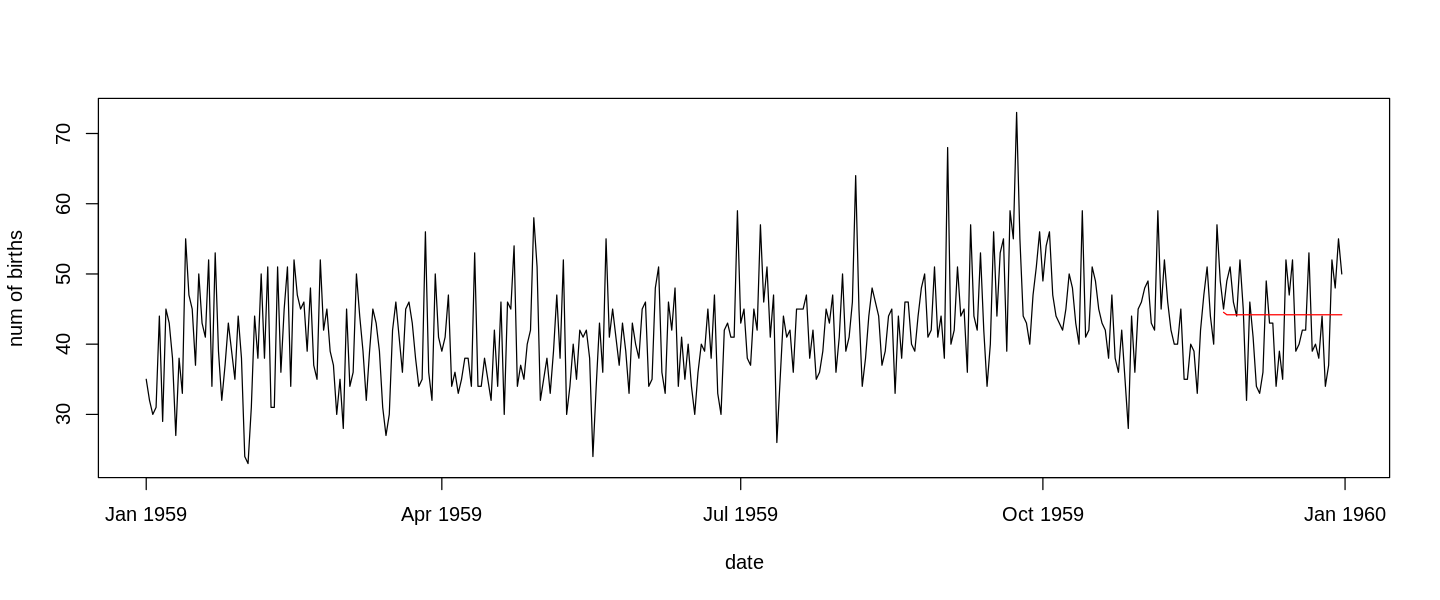

In [226]:
forecast_periods <- nrow(data_test)
forecast <- predict(model, n.ahead = forecast_periods)$pred
print(forecast)

plot(data$date, data$births, type="l", col="black", xlab="date", ylab= "num of births")
lines(data_test$date, forecast, col="red")

Based on the forecast, our model did not perform well as expected.

 A possible cause of the mediocre results would be because of our data which represent daily births, which might have a daily seasonality (more births on weekdays).
 * we try with Seasonal ARIMA aka SARIMA to see how it performs.


## ***Seasonal ARIMA***

In [227]:


# Build the SARIMA model (adjust order parameters based on data analysis)
model_seas <- auto.arima(data_train$births, seasonal = TRUE)
summary(model_seas)


Series: data_train$births 
ARIMA(0,1,2) 

Coefficients:
          ma1      ma2
      -0.8584  -0.0947
s.e.   0.0529   0.0530

sigma^2 = 50.45:  log likelihood = -1105.23
AIC=2216.45   AICc=2216.53   BIC=2227.82

Training set error measures:
                    ME    RMSE      MAE       MPE     MAPE      MASE
Training set 0.4753456 7.07027 5.519108 -1.596143 13.42783 0.7476174
                     ACF1
Training set -0.001680274

In [250]:

# Fit SARIMA model with order (p, d, q) and seasonal order (P, D, Q) with period m
sarima_model <- arima(data_train$births, order = c(0, 1, 2), seasonal = list(order = c(0, 1, 2), period = 12))

# Summary of the SARIMA model
summary(sarima_model)

Warning message in trainingaccuracy(object, test, d, D):
“test elements must be within sample”



Call:
arima(x = data_train$births, order = c(0, 1, 2), seasonal = list(order = c(0, 
    1, 2), period = 12))

Coefficients:
          ma1      ma2     sma1    sma2
      -0.8557  -0.0864  -1.0647  0.1243
s.e.   0.0542   0.0552   0.0646  0.0614

sigma^2 estimated as 51.91:  log likelihood = -1084.47,  aic = 2176.94

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN

Warning message in adf.test(residuals):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  residuals
Dickey-Fuller = -6.4755, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


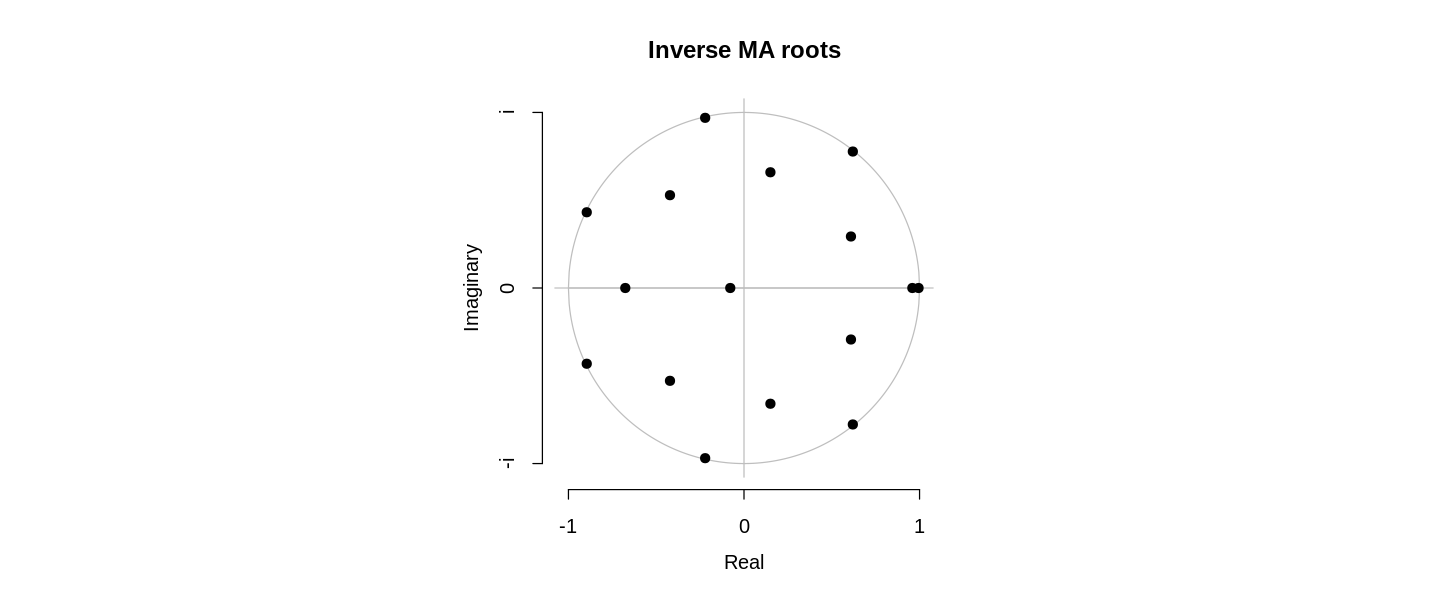

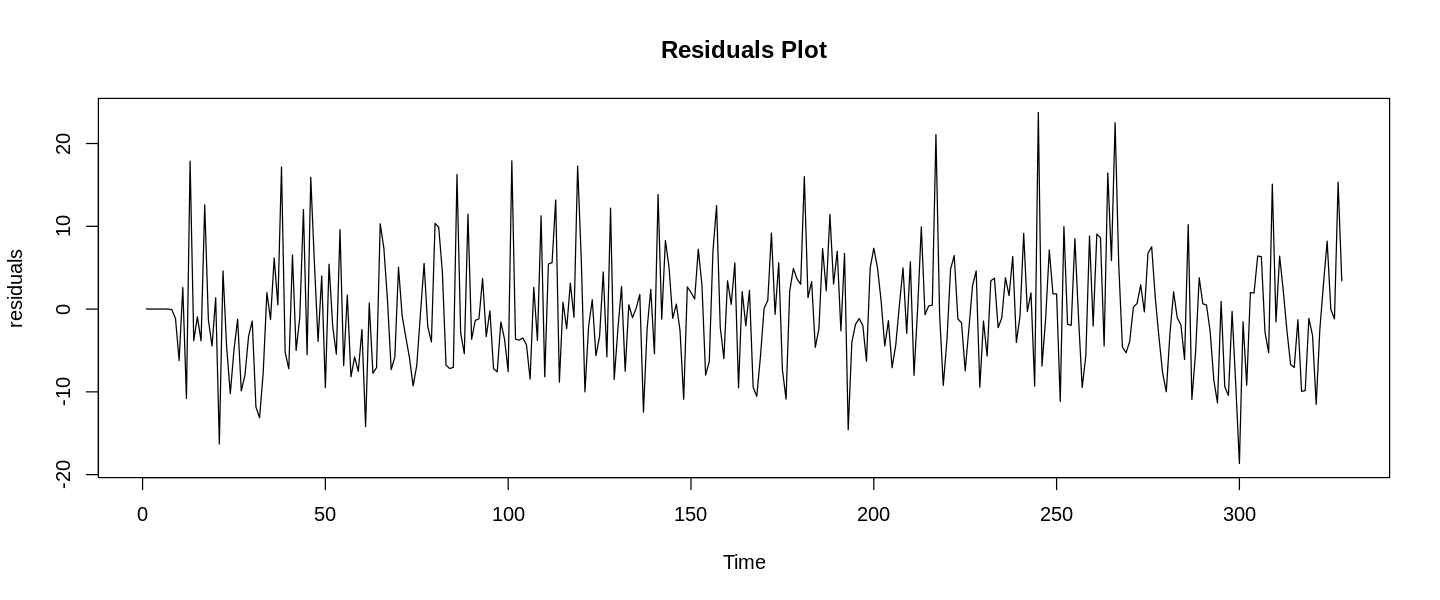

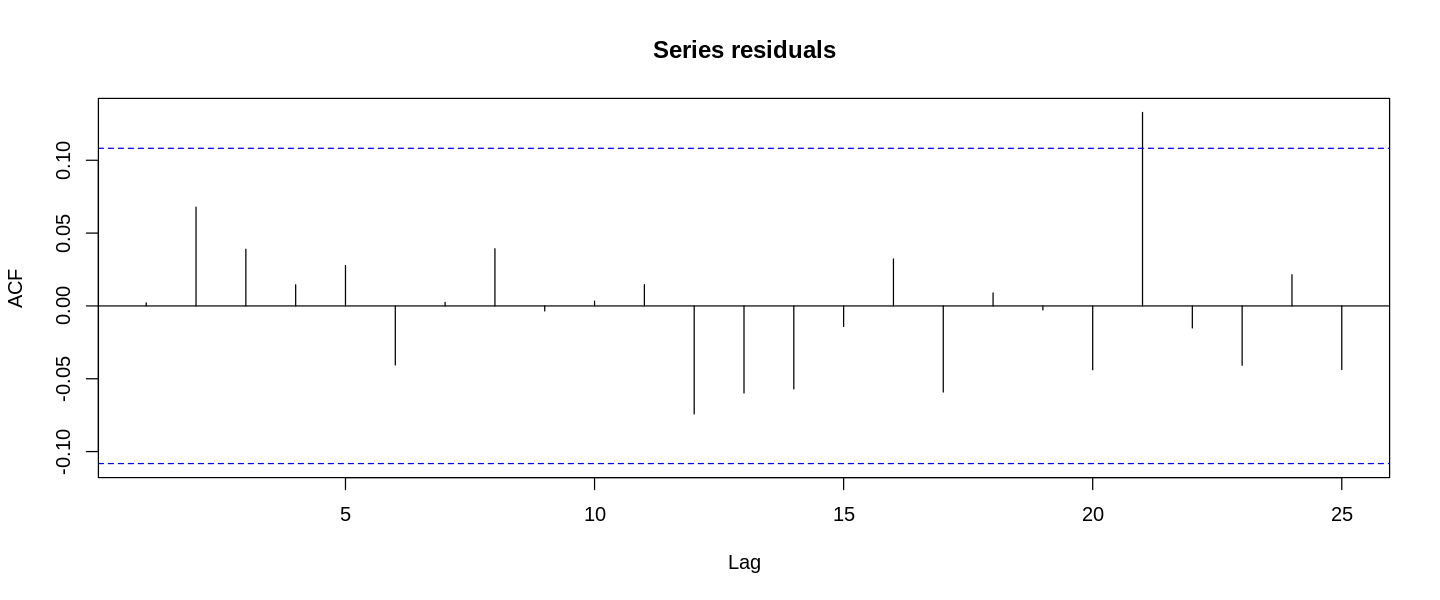

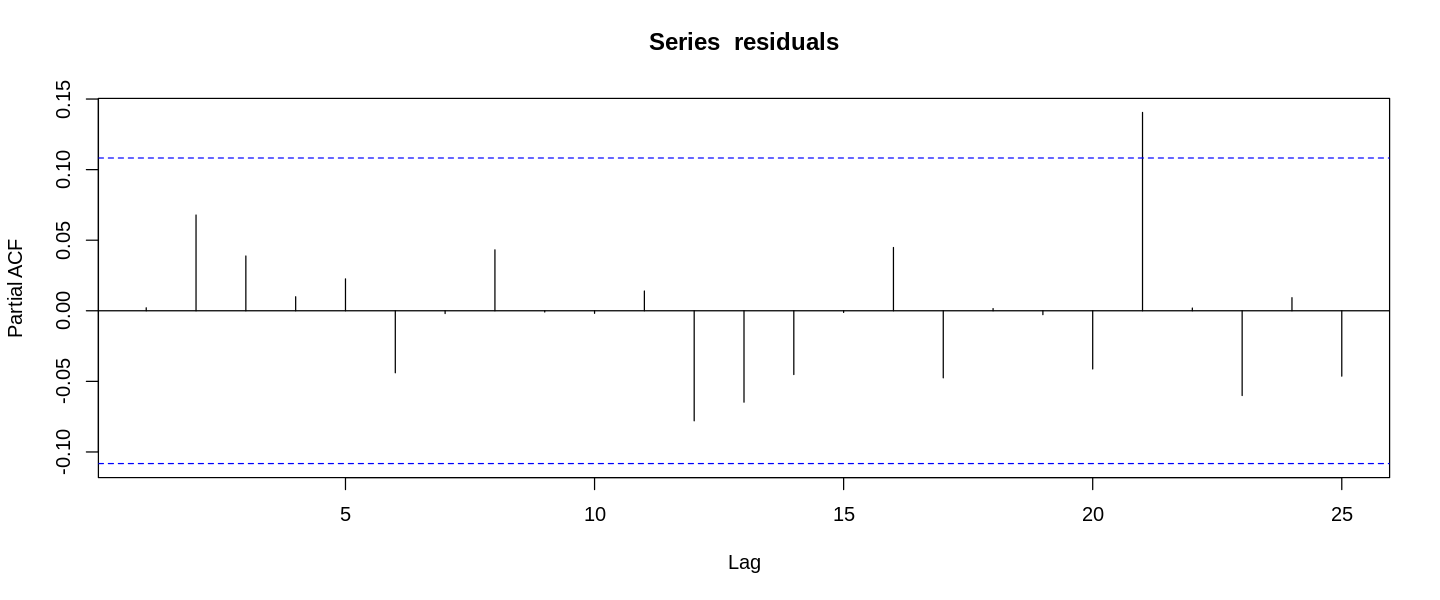

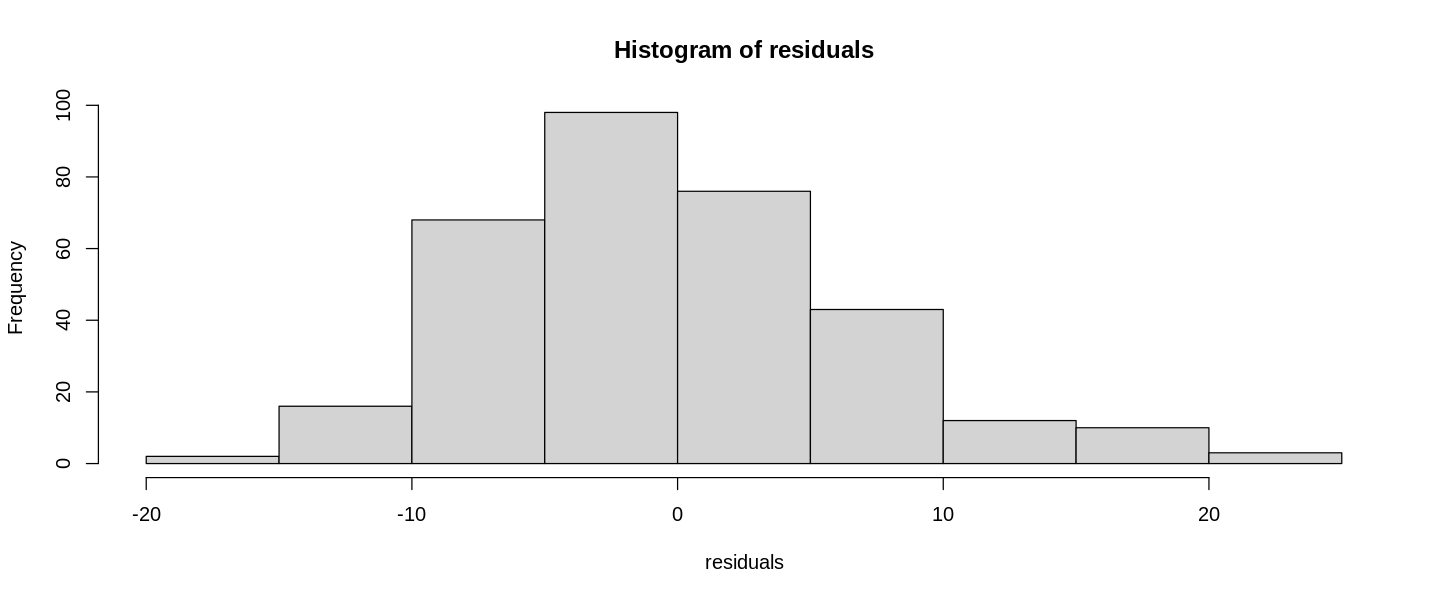

$pvalue
[1] 0.57

$observed.runs
[1] 157

$expected.runs
[1] 162.561

$n1
[1] 184

$n2
[1] 144

$k
[1] 0


	Shapiro-Wilk normality test

data:  residuals
W = 0.97837, p-value = 7.578e-05


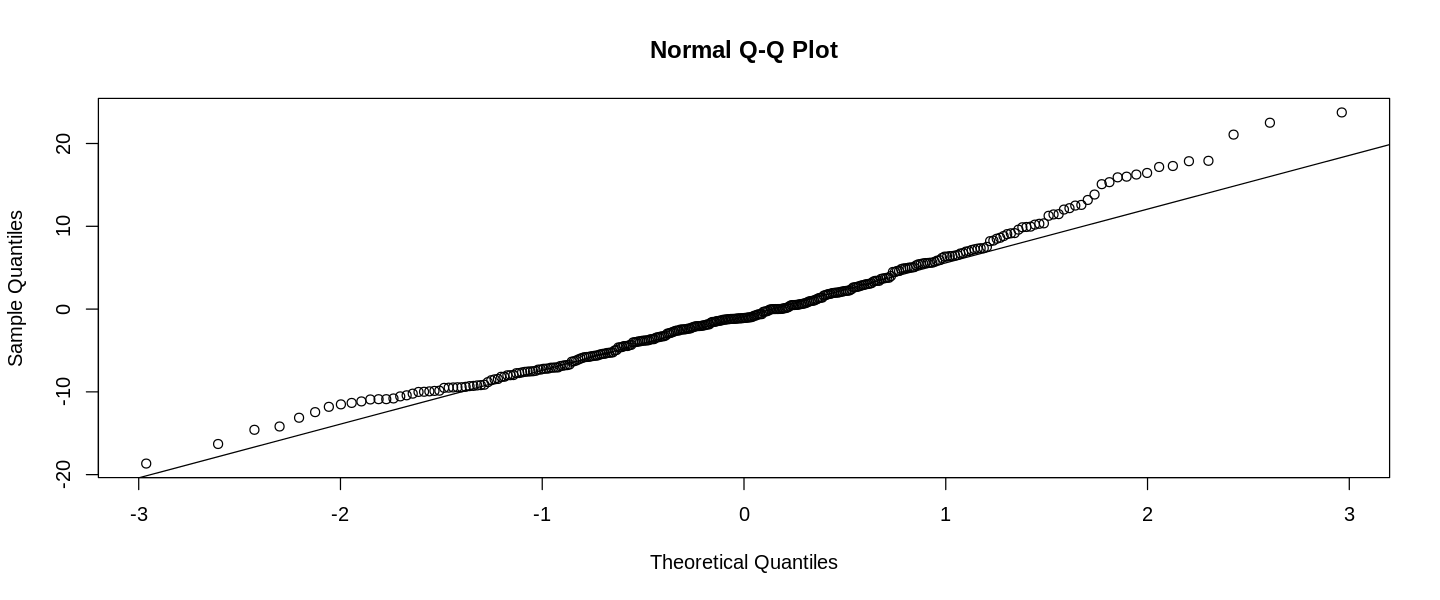

In [247]:
plot(sarima_model)
residuals <- residuals(sarima_model)

# 1. Check for Stationarity
adf.test(residuals)

# 2. Plot the Residuals
plot(residuals, type = "l", main = "Residuals Plot")

# 3. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
# Example:
acf(residuals)
pacf(residuals)

# 4. Normality
# Histogram
hist(residuals)
# Q-Q plot
qqnorm(residuals)
qqline(residuals)
# runs test
runs(residuals)
#shapiro test
shapiro.test(residuals)


Time Series:
Start = 329 
End = 365 
Frequency = 1 
 [1] 47.57333 44.62696 44.13770 45.44912 46.49183 46.65831 43.08258 44.69549
 [9] 45.49760 45.05710 42.91079 42.21345 45.83407 43.77523 43.85529 44.84074
[17] 45.30803 46.29445 43.86308 45.61675 45.47551 44.58323 44.70696 43.25602
[25] 46.07793 43.95425 44.03431 45.01976 45.48705 46.47347 44.04210 45.79577
[33] 45.65454 44.76225 44.88598 43.43504 46.25695
Time Series:
Start = 1 
End = 37 
Frequency = 1 
 [1] 45 49 51 46 44 52 45 32 46 41 34 33 36 49 43 43 34 39 35 52 47 52 39 40 42
[26] 42 53 39 40 38 44 34 37 52 48 55 50


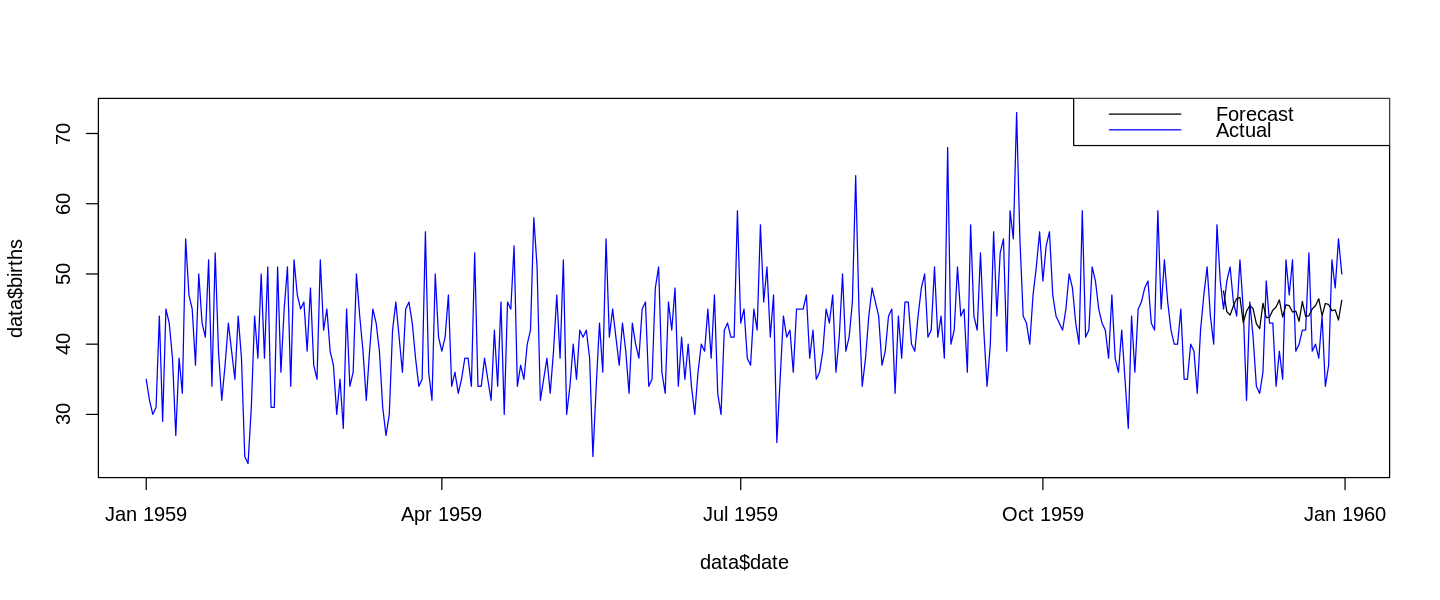

In [251]:
forecast_values <- predict(sarima_model,n.ahead = forecast_periods)$pred
# Print the forecasted values
print(forecast_values)

# Visualize actual vs. forecasted values
plot(data$date, data$births, col = "blue", type="l")
lines(data_test$date, forecast_values, main = "Forecasted vs. Actual Values", type="l")
legend("topright", legend = c("Forecast", "Actual"), col = c("black", "blue"), lty = 1)

print(ts(data_test$births))


### Results:
After using SARIMA(0,1,2) with seosonal order 12, we have seen a slight difference in the forecast results. The SARIMA model performed better than the ARIMA model. But still the SARIMA model failed to capture all the trends(It failed the normality test)

# **Conclusion**
* This study investigated daily variations in female births across California for 1959. By leveraging this unique dataset, we aimed to identify factors influencing birth patterns within a specific year.
we started
* We initially explored ARIMA and SARIMA models to capture these variations. While both models were fitted and diagnostics were performed, they did not yield definitive results. The ARIMA(0,1,2) model provided a starting point, capturing some short-term trends. However, further exploration using diagnostic tests revealed limitations, such as potential non-normality of residuals. Additionally, incorporating SARIMA terms for seasonality did not significantly improve the model's performance.

* These findings suggest that daily birth variations in California during 1959 may be influenced by more complex factors beyond what these models could capture. Further research avenues could include:

    * Exploring alternative time series forecasting methods like exponential smoothing or machine learning models.
  
    * Segmenting the data by geographic regions within California to identify potential local variations.

Despite the limitations of the initial models, this study highlights the complexity of daily birth variations.  Future research that explores these alternative approaches can lead to a more comprehensive understanding of the factors influencing daily births and their implications for healthcare resource allocation and societal trend analysis.


